## Problem 3: Pandemic Flu Spread

Consider a classroom of 61 elementary school kids. 60 of the kids are healthy (and susceptible to flu) on Day 1. Tommy (the 61st kid) walks in with the flu and starts interacting with his potential victims. To keep things simple, let's suppose that Tommy comes to school every day (whether or not he’s sick) and will be infectious for 3 days.

Thus, there are 3 chances for Tommy to infect the other kids — Days 1, 2, and 3. Suppose that the probability that he infects any individual susceptible kid on any of the three days is \( p = 0.01 \); and suppose that all kids and days are independent (so that you have i.i.d. Bern($p$) trials).

If a kid gets infected by Tommy, they will then become infectious for 3 days as well, starting on the next day.

**Questions**:

**(a)** What is the distribution of the number of kids that Tommy infects on Day 1?

**(b)** What is the expected number of kids that Tommy infects on Day 1?

**(c)** What is the expected number of kids that are infected by Day 2 (you can count Tommy if you want)?

**(d)** Simulate the number of kids that are infected on Days 1, 2, etc. Perform this simulation multiple times to estimate the expected number of kids that are infected by Day \(i\), for \(i = 1, 2, \dots\). Produce a histogram detailing how long the "epidemic" will last.

**(e)** What if each kid has a 50-50 chance of already being immunized (and the immunization works perfectly)?


In [1]:
import logging
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import simpy

In [2]:
class FluSpread:
    def __init__(
        self,
        env,
        num_kids,
        infection_prob,
        infectious_days,
        immunization_rate=0,
        until=100,
        verbose=True,
        log_to_file=True,
    ):
        self.env = env
        self.num_kids = num_kids
        self.infection_prob = infection_prob
        self.infectious_days = infectious_days
        self.immunization_rate = immunization_rate
        self.until = until
        self.verbose = verbose
        self.log_to_file = log_to_file

        self.immunized_kids = [
            kid for kid in range(num_kids) if random.random() < self.immunization_rate
        ]

        self.susceptible_kids = [
            kid for kid in range(num_kids) if kid not in self.immunized_kids
        ]

        self.infected_kids = []

        # Data to track daily states of kids
        self.data = defaultdict(
            lambda: {
                "susceptible": [],
                "infected": [],
                "immunized": [],
            }
        )

        # Set up logging
        self._setup_logger()

    def start_infection(self):
        """
        Start the infection process with Tommy (initial infected kid).
        """
        patient_zero = len(self.susceptible_kids) + 1
        self.infected_kids.append(patient_zero)
        self.data[self.env.now]["infected"].append(patient_zero)
        self.data[self.env.now]["susceptible"] = sorted(self.susceptible_kids)
        self.data[self.env.now]["immunized"] = sorted(self.immunized_kids)
        self.env.process(self.infect_process())
        self.env.process(self.recover_kid(patient_zero))

    def infect_process(self):
        """
        Simulate the process of infection for each day.
        """
        day = 0
        while day < self.until:
            yield self.env.timeout(1)
            day += 1

            if len(self.infected_kids) > 0:
                new_infections = self.attempt_infection()
                for kid in new_infections:
                    self.susceptible_kids.remove(kid)
                    self.infected_kids.append(kid)
                    self.env.process(self.recover_kid(kid))
                    self.logger.info(f"Day {self.env.now}: Kid {kid} got infected")

            self.data[self.env.now]["infected"] = sorted(self.infected_kids)
            self.data[self.env.now]["susceptible"] = sorted(self.susceptible_kids)
            self.data[self.env.now]["immunized"] = sorted(self.immunized_kids)

            self.logger.info(
                f"Day {self.env.now}: New Infections: {len(new_infections)}"
            )

            self.logger.info(
                f"Day {self.env.now}: Total Infections: {len(self.infected_kids)}"
            )

    def attempt_infection(self):
        """
        Attempt to infect susceptible kids based on the infection probability.
        Each infected kid has a chance to infect each susceptible kid.
        """
        new_infections = []

        # Iterate through all currently infected kids
        for _ in self.infected_kids:
            # Each infected kid tries to infect all susceptible kids
            for susceptible_kid in self.susceptible_kids:
                if random.random() < self.infection_prob:
                    # If the susceptible kid gets infected, add them to new infections list if not already infected
                    if susceptible_kid not in new_infections:
                        new_infections.append(susceptible_kid)

        return new_infections

    def recover_kid(self, kid):
        """
        Recover the infected kid after infectious_days.
        """
        yield self.env.timeout(self.infectious_days)
        self.infected_kids.remove(kid)
        self.susceptible_kids.append(kid)
        self.logger.info(f"Day {self.env.now}: Kid {kid} recovered")

    def _setup_logger(self):
        """
        Set up the logger for the FluSpread class.
        """
        self.logger = logging.getLogger("FluSpreadSimulation")

        # Remove any existing handlers attached to the logger
        if self.logger.hasHandlers():
            self.logger.handlers.clear()

        # Set up handler based on logging preferences
        if self.log_to_file:
            # Set up a FileHandler if log_to_file is True
            handler = logging.FileHandler("flu_simulation.log")
        else:
            handler = logging.StreamHandler()

        # Set the log formatter
        formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        )

        handler.setFormatter(formatter)
        self.logger.addHandler(handler)

        # Set logging level based on verbosity
        if self.verbose:
            self.logger.setLevel(logging.INFO)
        else:
            self.logger.setLevel(logging.WARNING)

In [3]:
# Run the simulation
def run_simulation(
    num_simulations=1000,
    **kwargs,
):
    simulation_results = []

    for simulation_number in range(num_simulations):
        # Create the SimPy environment
        env = simpy.Environment()

        # Initialize the FluSpread class
        flu_simulation = FluSpread(
            env,
            **kwargs,
        )

        # Start the infection process
        flu_simulation.start_infection()

        # Run the simulation
        env.run()

        # Append the simulation data

        simulation_results.extend(
            {
                "simulation": simulation_number,
                "day": day,
                "infected": len(data["infected"]),
                "susceptible": len(data["susceptible"]),
            }
            for day, data in flu_simulation.data.items()
        )

    return pd.DataFrame(simulation_results)

In [4]:
def summary(simulation_results):
    # Create a figure with multiple subplots (2 rows, 2 columns)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Pandemic Flu Spread Analysis", fontsize=16)

    # Subplot 1: Histogram of Number of Kids Tommy Infected on Day 1
    tmp = simulation_results[simulation_results["day"] == 1]["infected"]
    axs[0, 0].hist(
        tmp,
        bins=range(tmp.min(), tmp.max() + 2),
        edgecolor="black",
        alpha=0.7,
        density=True,
    )

    axs[0, 0].set_xlabel("Number of Infected Kids")
    axs[0, 0].set_ylabel("Frequency")
    axs[0, 0].set_title("Histogram of Kids Infected on Day 1")
    axs[0, 0].grid(axis="y", linestyle="--")

    # Print the expected number of kids infected on Day 1
    print(f"Expected number of kids that Tommy infects on Day 1: {tmp.mean()}")

    # Subplot 2: Expected Number of Infected Kids by Day 2
    tmp = simulation_results[simulation_results["day"] == 2]["infected"]
    print(f"Expected number of infected kids (including Tommy) on Day 2: {tmp.mean()}")

    # Subplot 3: Expected Number of Infected Kids by Day
    tmp = simulation_results.groupby(["day"]).agg(infected=("infected", "mean"))
    axs[0, 1].plot(tmp.index, tmp.values, marker="o")
    axs[0, 1].set_xlabel("Day")
    axs[0, 1].set_ylabel("Expected Number of Infected Kids")
    axs[0, 1].set_title("Expected Number of Infected Kids by Day")
    axs[0, 1].grid(axis="both", linestyle="--")

    # Subplot 4: Histogram of Epidemic Duration Across Simulations
    tmp = (
        simulation_results[simulation_results["infected"] == 0]
        .groupby(["simulation"])
        .agg(day=("day", "min"))
    )

    axs[1, 0].hist(
        tmp["day"],
        edgecolor="black",
        alpha=0.7,
        density=True,
    )

    axs[1, 0].set_xlabel("Number of Days Until Zero Infections")
    axs[1, 0].set_ylabel("Frequency")
    axs[1, 0].set_title("Histogram of Epidemic Duration")
    axs[1, 0].grid(axis="y", linestyle="--")

    # Remove the unused subplot (bottom right)
    fig.delaxes(axs[1, 1])

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
# Define key parameters
num_kids = 60  # Number of susceptible kids
infection_prob = 0.01  # Probability of infecting each kid per day
infectious_days = 3  # Number of days a kid remains infectious
until = 150  # Number of days to run the simulation
num_simulations = 5000  # Number of simulations to run

Expected number of kids that Tommy infects on Day 1: 1.5912
Expected number of infected kids (including Tommy) on Day 2: 2.5212


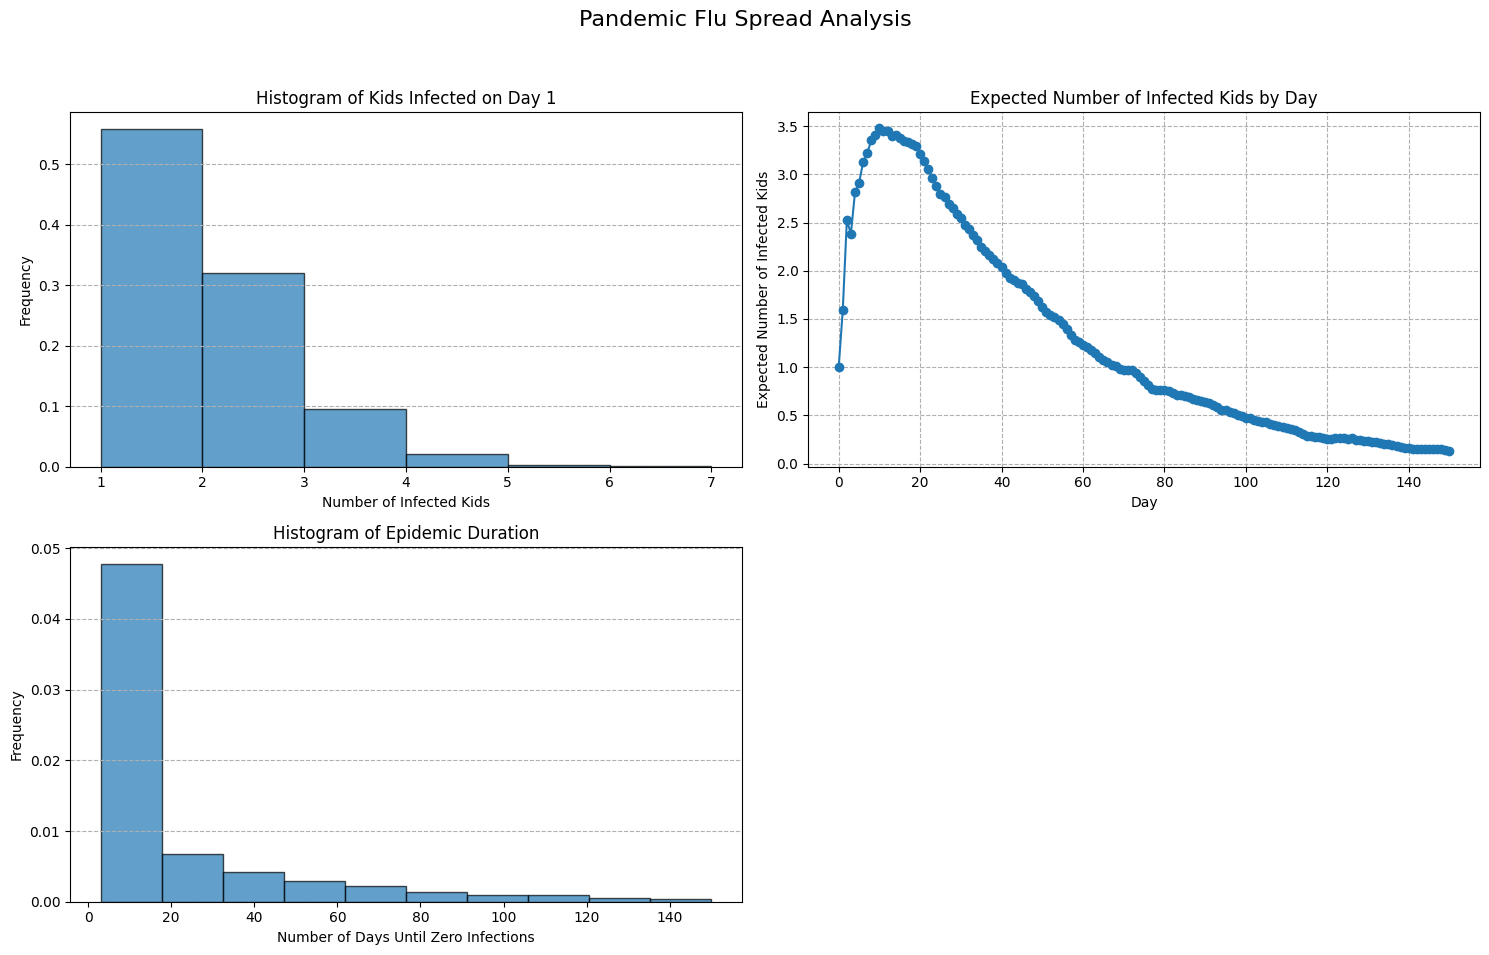

In [6]:
simulation_results = run_simulation(
    num_simulations=num_simulations,
    num_kids=num_kids,
    infection_prob=infection_prob,
    infectious_days=infectious_days,
    until=until,
    verbose=False,
    log_to_file=False,
)

summary(simulation_results)

Expected number of kids that Tommy infects on Day 1: 1.3076
Expected number of infected kids (including Tommy) on Day 2: 1.693


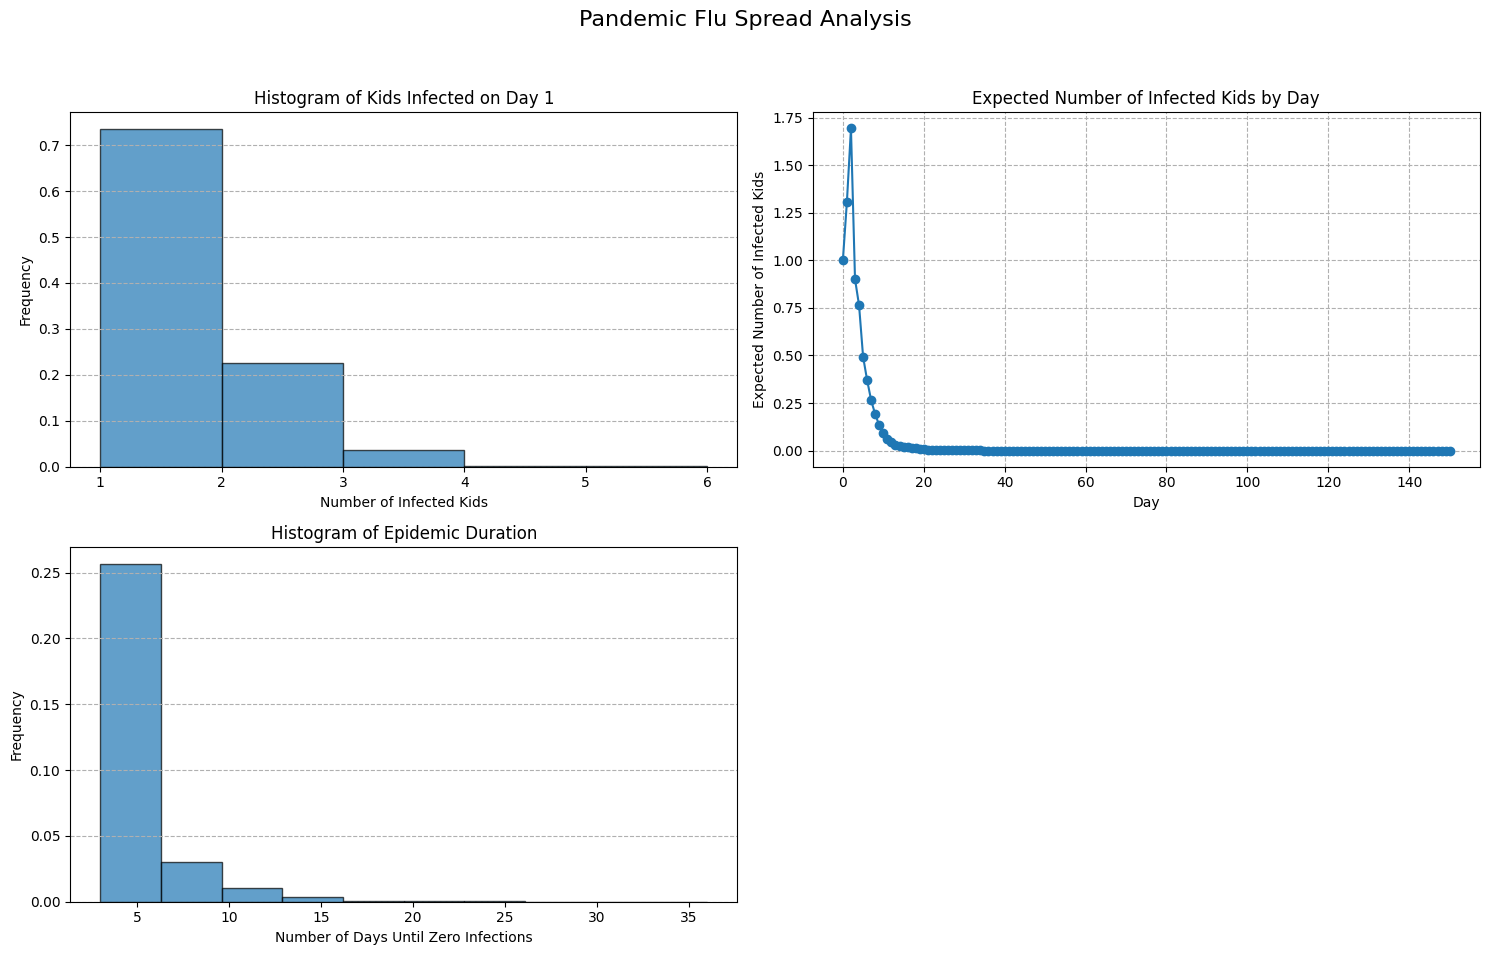

In [7]:
immunization_rate = 0.5  # Percentage of kids immunized

simulation_results = run_simulation(
    num_simulations=num_simulations,
    num_kids=num_kids,
    infection_prob=infection_prob,
    infectious_days=infectious_days,
    immunization_rate=immunization_rate,
    until=until,
    verbose=False,
    log_to_file=False,
)

summary(simulation_results)